In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization

import matplotlib.pyplot as plt
print('Tensorflow version: ', tf.__version__)
print('GPU available: ', tf.config.list_physical_devices('GPU'))


Tensorflow version:  2.6.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Download IMDB Dataset

In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 13s 0us/step


# Data reorganization

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


# Data inspection

In [5]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

# BERT model

In [6]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
model_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
model_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

# Input preprocessing

In [7]:
bert_preprocess_model = hub.KerasLayer(model_preprocess)

# Preprocessor example

In [8]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


# Output example

In [11]:
bert_model = hub.KerasLayer(model_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {model_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76282805  0.9928181  -0.18577962  0.36684927  0.15222977  0.65488696
  0.9680216  -0.9485936   0.00202909 -0.9877595   0.06832406 -0.9763315 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28928757  0.34428132  0.33205402 ...  0.21326737  0.7094139
  -0.05716754]
 [-0.287522    0.32000062 -0.23001459 ...  0.58415353 -0.21408522
   0.72644454]
 [-0.6610728   0.68889487 -0.87432784 ...  0.10865067 -0.2621953
   0.47855395]
 ...
 [-0.2256634  -0.28888845 -0.07135235 ...  0.4760908   0.8327153
   0.40016565]
 [-0.29826814 -0.27394095 -0.05525298 ...  0.4891016   1.0950427
   0.18138489]
 [-0.44274697  0.01015296  0.07241834 ...  0.17331156  1.1835047
   0.07891317]]


# Fine-tuning with BERT

In [12]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(model_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(model_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

# Test the model maker
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.81418437]], shape=(1, 1), dtype=float32)


## Train

In [14]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {model_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 150s 234ms/step - loss: 0.4962 - binary_accuracy: 0.7440 - val_loss: 0.3731 - val_binary_accuracy: 0.8424
Epoch 2/5
625/625 [==============================] - 141s 226ms/step - loss: 0.3333 - binary_accuracy: 0.8539 - val_loss: 0.3667 - val_binary_accuracy: 0.8458
Epoch 3/5
625/625 [==============================] - 143s 229ms/step - loss: 0.2574 - binary_accuracy: 0.8914 - val_loss: 0.3856 - val_binary_accuracy: 0.8512
Epoch 4/5
625/625 [==============================] - 148s 236ms/step - loss: 0.1983 - binary_accuracy: 0.9210 - val_loss: 0.4204 - val_binary_accuracy: 0.8532
Epoch 5/5
625/625 [==============================] - 144s 231ms/step - loss: 0.1548 - binary_accuracy: 0.9409 - val_loss: 0.4616 - val_binary_accuracy: 0.8534


## Evaluate

782/782 [==============================] - 105s 134ms/step - loss: 0.4478 - binary_accuracy: 0.8568
Loss: 0.4477924704551697
Accuracy: 0.8568400144577026
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


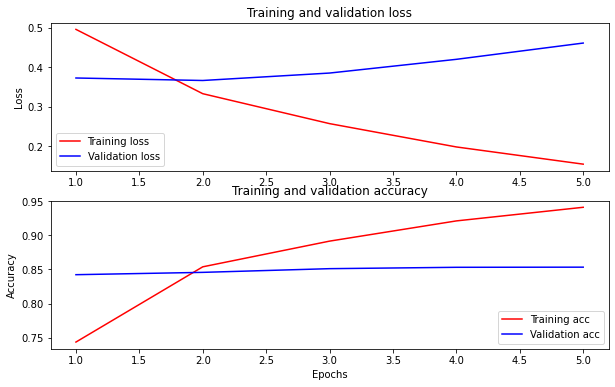

In [15]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Save model

In [16]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./imdb_bert\assets


INFO:tensorflow:Assets written to: ./imdb_bert\assets


## Load model

In [17]:
reloaded_model = tf.saved_model.load(saved_model_path)

## Test inference

In [18]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999078
input: The movie was great!           : score: 0.996821
input: The movie was meh.             : score: 0.978775
input: The movie was okish.           : score: 0.131617
input: The movie was terrible...      : score: 0.000826

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999078
input: The movie was great!           : score: 0.996821
input: The movie was meh.             : score: 0.978775
input: The movie was okish.           : score: 0.131617
input: The movie was terrible...      : score: 0.000826

